In [14]:
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
koppen_index = np.load('koppen_index.npy').astype('float')
koppen_index[koppen_index==0] = np.nan
koppen_index = np.concatenate((koppen_index[:, 181:], koppen_index[:,:181]), axis=-1)

for i in range(1,4):
    koppen_index[koppen_index==i]=0
for i in range(4,6):
    koppen_index[koppen_index==i]=1
for i in range(6,8):
    koppen_index[koppen_index==i]=2
for i in range(8,11):
    koppen_index[koppen_index==i]=3
for i in range(11,14):
    koppen_index[koppen_index==i]=4
for i in range(14,17):
    koppen_index[koppen_index==i]=5
for i in range(17,21):
    koppen_index[koppen_index==i]=6
for i in range(21,25):
    koppen_index[koppen_index==i]=7
for i in range(25,29):
    koppen_index[koppen_index==i]=8
for i in range(29,31):
    koppen_index[koppen_index==i]=9

In [ ]:
bias, rmse, nse, wi, kge, r, m1, m2,mae, mse, score_ = output_preprocessor(
        mdl_list=mdl_list, 
        file_path=file_path,  
        file_type=file_type)
for i in range(1):
    mask = np.where(koppen_index==i)
    plt.boxplot(score_[:, mask[0],mask[1]].reshape(10, -1))

In [ ]:
lon, lat = np.meshgrid(np.arange(-178.5, 181.5,1), np.arange(90, -90,-1))

plt.figure(figsize=(14,10))


colors = ('red','#FF1493' ,'#FFC0CB','#20B2AA','#32CD32','#7CFC00','#00FFFF','#00BFFF','#0000FF','gray')
m = Basemap()
m.drawcoastlines(linewidth=0.2)
x, y = m(lon, lat)

levels = [-0.5, 0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5]
sc = m.contourf(x, y, koppen_index,
                colors=colors,
                levels=levels,
                vmin=-1,
                vmax=10)

proxy = [plt.Rectangle((0,0),1,1,fc=pc.get_facecolor()[0]) for pc in sc.collections]
title = ['Tropical', 'Arid, desert','Arid, steppe','Temperate, dry summer','Temperate, dry winter',
        'Temperate, no dry season', 'Cold, dry summer','Cold, dry winter','Cold, no dry season','Polar']

plt.legend(proxy, title, loc='left',bbox_to_anchor=(0.255,0.56))

plt.savefig('koppen_index.pdf')

In [53]:
import pickle

f = open('saved_model_0.pickle', 'rb')
log = pickle.load(f)

In [54]:
a  = log['y_pred']

In [55]:
a.shape

(2677, 18, 18)

In [60]:
np.isnan(a).any()

True

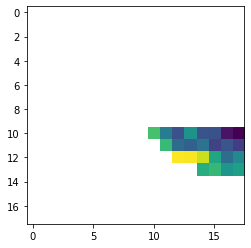

In [62]:
plt.imshow(np.mean(a, axis=0))

In [9]:

def plot_taylor_diagram(stddev,
                        corrcoef,
                        refstd,
                        fig,
                        colors,
                        normalize=True):
    """Plot a taylor diagram

    Args:
        stddev : numpy.ndarray
            an array of standard deviations
        corrcoeff : numpy.ndarray
            an array of correlation coefficients
        refstd : float
            the reference standard deviation
        fig : matplotlib figure
            the matplotlib figure
        colors : array
            an array of colors for each element of the input arrays
        normalize : bool, optional
            disable to skip normalization of the standard deviation
    """

    import mpl_toolkits.axisartist.grid_finder as GF
    import mpl_toolkits.axisartist.floating_axes as FA
    from matplotlib.projections import PolarAxes

    # define transform
    tr = PolarAxes.PolarTransform()

    # correlation labels
    rlocs = np.concatenate((np.arange(10)/10., [0.95, 0.99]))
    tlocs = np.arccos(rlocs)
    gl1 = GF.FixedLocator(tlocs)
    tf1 = GF.DictFormatter(dict(zip(tlocs, map(str, rlocs))))

    # standard deviation axis extent
    if normalize:
        stddev = stddev/refstd
        refstd = 1.
    smin = 0
    smax = max(2.0, 1.1*stddev.max())

    # add the curvilinear grid
    ghelper = FA.GridHelperCurveLinear(tr,
                                       extremes=(0, np.pi/2, smin, smax),
                                       grid_locator1=gl1,
                                       tick_formatter1=tf1)
    ax = FA.FloatingSubplot(fig, 111, grid_helper=ghelper)
    fig.add_subplot(ax)

    # adjust axes
    ax.axis["top"].set_axis_direction("bottom")
    ax.axis["top"].toggle(ticklabels=True, label=True)
    ax.axis["top"].major_ticklabels.set_axis_direction("top")
    ax.axis["top"].label.set_axis_direction("top")
    ax.axis["top"].label.set_text("Correlation")
    ax.axis["left"].set_axis_direction("bottom")
    if normalize:
        ax.axis["left"].label.set_text("Normalized standard deviation")
    else:
        ax.axis["left"].label.set_text("Standard deviation")
    ax.axis["right"].set_axis_direction("top")
    ax.axis["right"].toggle(ticklabels=True)
    ax.axis["right"].major_ticklabels.set_axis_direction("left")
    ax.axis["bottom"].set_visible(False)
    ax.grid(True)

    ax = ax.get_aux_axes(tr)
    # Plot data
    corrcoef = corrcoef.clip(-1, 1)
    for i in range(len(corrcoef)):
        ax.plot(np.arccos(corrcoef[i]), stddev[i],
                'o', color=colors[i], mew=0, ms=8)

    # Add reference point and stddev contour
    l, = ax.plot([0], refstd, 'k*', ms=12, mew=0)
    t = np.linspace(0, np.pi/2)
    r = np.zeros_like(t) + refstd
    ax.plot(t, r, 'k--')

    # centralized rms contours
    rs, ts = np.meshgrid(np.linspace(smin, smax),
                         np.linspace(0, np.pi/2))
    rms = np.sqrt(refstd**2 + rs**2 - 2*refstd*rs*np.cos(ts))
    contours = ax.contour(ts, rs, rms, 5, colors='k', alpha=0.4)
    ax.clabel(contours, fmt='%1.1f')

    return ax

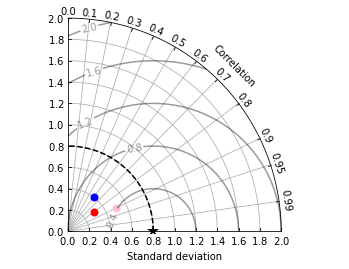

In [11]:
import matplotlib.pyplot as plt
import numpy as np
std = np.array([0.3,0.4,0.5])
corr = np.array([0.8,0.6,0.9])

fig=plt.figure()
plot_taylor_diagram(stddev=std, corrcoef=corr, refstd=0.8, fig=fig, colors=['red','blue','pink'], normalize=False)

In [17]:
a = np.array(1)


In [21]:

import os
np.save(os.path.join('Desktop','1.npy'), a)

FileNotFoundError: [Errno 2] No such file or directory: 'Desktop/1.npy'